In [12]:
import torch
import pprint as pp
import torchvision
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
import numpy as np
from operator import add
import matplotlib.pyplot as plt

In [13]:
# hyperparameters

batch_size = 64
num_caps = 16
learning_rate = 0.01
weight_decay = 1e-5
momentum = 0.5
torch.backends.cudnn.enabled = False

In [14]:
# Create data loaders.

transform = torchvision.transforms.Compose([
              torchvision.transforms.ToTensor(),
            ])
train_dataloader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=transform),
  batch_size=batch_size, shuffle=True, drop_last=True)

test_dataloader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=transform),
  batch_size=batch_size, shuffle=True, drop_last=True)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


In [15]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


$$
W_{30\times20} \times g(W_{20\times10} \times x_{10}) 
\neq (W_{30\times20} \times W_{20\times10}) \times x_{10} 
= W_{30\times 10} \times x_{10}
$$

In [16]:
def shift_image(image):
    dx = np.random.randint(-3, 4)
    dy = np.random.randint(-3, 4)
    image = torch.roll(image, dx, -1)
    image = torch.roll(image, dy, -2)
    return image, dx, dy

In [17]:
class Capsule(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            # N, 1, 28, 28
            nn.Conv2d(1, 16, 3, padding=1, bias=False),
            nn.BatchNorm2d(16), 
            nn.ReLU(True),
            nn.MaxPool2d(2), # 14
            
            nn.Conv2d(16, 8, 3, padding=1, bias=False),
            nn.BatchNorm2d(8), 
            nn.ReLU(True),
            nn.MaxPool2d(2), # 7
        )
    
        self.lin = nn.Sequential(
            nn.Linear(8, 3),
        )

        self.decoder_lin = nn.Sequential(
            nn.Linear(2, 4*49), 
        )

        self.decoder = nn.Sequential(
            nn.ReLU(True),
            nn.ConvTranspose2d(4, 32, 3, stride=2, padding=1, bias=False, output_padding=1), # B, 8, 14, 14
            nn.BatchNorm2d(32), 
            nn.ReLU(True),

            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, bias=True, output_padding=1), # B, 1, 28, 28  
            nn.Sigmoid()
        )

        self.sig = nn.Sigmoid()

    def encode(self, x):
        x = self.encoder(x)
        x = x.mean(-1).mean(-1)
        z = self.lin(x)
        p = z[:,[0]]
        p = self.sig(p)
        xy = z[:,[1,2]]
        return p, xy
    
    
    def decode(self, xy):
        xy = self.decoder_lin(xy)
        xy = torch.reshape(xy, (64, 4 ,7 , 7))
        return self.decoder(xy)
    
capsule = Capsule().to(device)

In [18]:
# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.encoder = nn.Sequential(
#             nn.Conv2d(1, 512, 5, stride=2, padding=1), # N, 8, 14, 14
#             nn.ReLU(True)

#         )
#         self.lin_encoder =  nn.Sequential(
#             nn.Linear(512, 3)
#         )

#         self.decoder_lin = nn.Linear(2, 4*7*7) # B, 4, 7, 7
        
#         self.decoder = nn.Sequential(
#             nn.ReLU(True),
#             nn.ConvTranspose2d(4, 128, 3, padding=1, bias=False),
#             nn.BatchNorm2d(128), 
#             nn.ReLU(True),
#             nn.ConvTranspose2d(128, 64, 3, stride = 2, padding=1, bias=False, output_padding=1),
#             nn.BatchNorm2d(64), 
#             nn.ReLU(True),
#             nn.ConvTranspose2d(64, 1, 3, stride = 2, padding=1, output_padding=1),
#             nn.Sigmoid()
#         )

#         self.prob = nn.Sigmoid()
        
#     def encode(self, x):
#         x = self.encoder(x)
#         x = x.mean(-1).mean(-1)
#         x = self.lin_encoder(x)
#         p = self.prob(x[:,0].view(64,1))
#         return p, torch.column_stack((x[:,1].view(64,1),x[:,2].view(64,1)))
    
    
#     def decode(self, xy):
#         xy = self.decoder_lin(xy)
#         xy = torch.reshape(xy, (64, 4 ,7 , 7))
#         return self.decoder(xy)

In [19]:
class TAE(nn.Module):
    def __init__(self, num_caps=num_caps):
        super().__init__()
        self.caps = nn.ModuleList([
            Capsule().to(device) for _ in range(num_caps) 
        ])
    
    def forward(self, img, dx_dy):
        output_image = 0.0
        for caps in self.caps:
            p_list, xy_list = caps.encode(img)
            xy_shifted = xy_list + dx_dy
            img_rec = caps.decode(xy_shifted)
            img_rec = img_rec * p_list[:, :, None, None]
            output_image = output_image + img_rec

        return output_image
    
    

model = TAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model

TAE(
  (caps): ModuleList(
    (0): Capsule(
      (encoder): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (4): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): ReLU(inplace=True)
        (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (lin): Sequential(
        (0): Linear(in_features=8, out_features=3, bias=True)
      )
      (decoder_lin): Sequential(
        (0): Linear(in_features=2, out_features=196, bias=True)
      )
      (decoder): Sequential(
        (0): ReLU(inplace=True)
        (1): ConvTranspose2d(4, 32, kernel_size=(3, 

In [20]:
shifts = [
            [-2, -2], [-2, -1], [-2, 0], [-2, 1], [-2, 2],
            [-1, -2], [-1, -1], [-1, 0], [-1, 1], [-1, 2],
            [0, -2], [0, -1], [0, 0], [0, 1], [0, 2],
            [1, -2], [1, -1], [1, 0], [1, 1], [1, 2],
            [2, -2], [2, -1], [2, 0], [2, 1], [2, 2]
        ]

#shifts = (np.indices([5, 5]) - 2).reshape(2, -1).T

In [21]:
def train(train_loader):
    model.train()
    loss = 0
    criterion = nn.MSELoss().to(device)
    
    for batch_features, target in train_loader:

        batch_features, target = batch_features.to(device), target.to(device)
        new_features, dx, dy = shift_image(batch_features)

        optimizer.zero_grad()

        output_image = model(batch_features, torch.Tensor([dx, dy]).to(device))

        # compute training reconstruction loss
        train_loss = criterion(output_image, new_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss = loss + train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epochs + 1, epochs, loss))
    return output_image, batch_features

def test(test_loader):
    model.eval()
    outputs = []
    for batch_features, target in test_loader:
        batch_features, target = batch_features.to(device), target.to(device)

        for dx, dy in shifts:
            rolled_image = torch.roll(batch_features, dx, -1)
            rolled_image = torch.roll(rolled_image, dy, -2)
            new_features, dx, dy = shift_image(rolled_image)
            output_image = model(batch_features, torch.Tensor([dx, dy]).to(device))
            outputs.append(output_image)

        return outputs, target[0]

In [22]:
torch.autograd.set_detect_anomaly(True)

epochs = 8
outputs = []  
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    output, _ = train(train_dataloader)
    outputs.append(output)
shift_grid = test(test_dataloader)

print("Finished")

Epoch 1
-------------------------------
epoch : 9/8, loss = 0.137771
Epoch 2
-------------------------------
epoch : 9/8, loss = 0.060485
Epoch 3
-------------------------------
epoch : 9/8, loss = 0.055510
Epoch 4
-------------------------------
epoch : 9/8, loss = 0.050822
Epoch 5
-------------------------------
epoch : 9/8, loss = 0.047150
Epoch 6
-------------------------------
epoch : 9/8, loss = 0.044889
Epoch 7
-------------------------------
epoch : 9/8, loss = 0.042906
Epoch 8
-------------------------------
epoch : 9/8, loss = 0.041593
Finished


In [23]:
# for k in range(0, epochs, 4): 
#     plt.figure(figsize=(9, 2))
#     plt.gray()
#     imgs = outputs[k].detach().cpu().numpy()
#     for i, item in enumerate(imgs):
#         if i >= 9: break
#         plt.subplot(2,9, i+1)
#         plt.imshow(item[0])

#     for i, item in enumerate(recon):
#         if i >= 9: break
#         plt.subplot(2, 9, 9+i+1)
#         plt.imshow(item)



tensor(3, device='cuda:0')
tensor(1, device='cuda:0')
tensor(0, device='cuda:0')
tensor(6, device='cuda:0')
tensor(1, device='cuda:0')


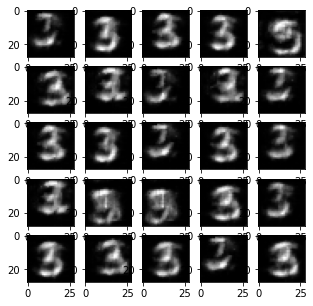

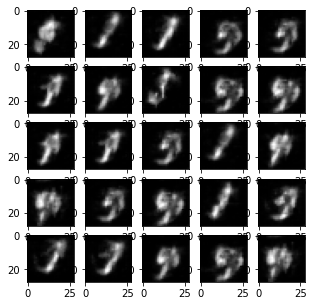

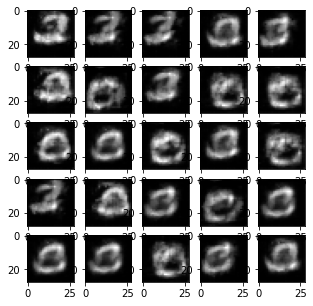

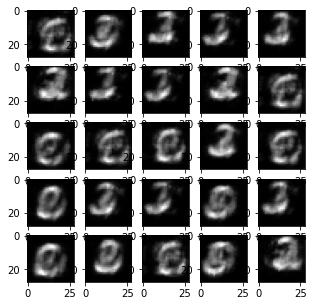

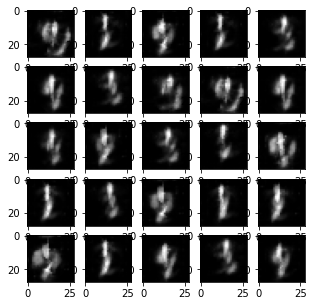

In [24]:
for _ in range(5):
  shift_grid, target = test(test_dataloader)
  print(target)
  plt.figure(figsize=(5, 5))
  plt.gray()
  for i, item in enumerate(shift_grid):
      item = item.detach().cpu().numpy()
      if i >= 25: break
      plt.subplot(5,5, i+1)
      plt.imshow(item[0][0])
